<a href="https://colab.research.google.com/github/SiPilip/pytorch_course/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Dataset

Kita sudah menggunakan beberapa dataset dengan pytorch before

Tetapi bagaiman jika kita ingin menggunakan data sendiri

Salah satu cara untuk melakukannya: Dataset kustom

## Domain Libraries

Bergantung pada apa yang kamu kerjakan, citra, teks, audio, kamu akan melihat tiap PyTorch domain libraries untuk data yang sudah ada berdasarkan fungsi dan kustom data loader

# 0. Import PyTorch dan setup agnostic device

In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu124'

In [2]:
# Setup perangkat agnostik
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cpu'

## 1. Ambil Data

Dataset kita adalah subset dari Food101 Dataset

Food101 dimulai dari 101 kelas berbeda dari makanan (750 Training, 250 Testing)

Dataset kita dimulai dari 3 kelas dan hanya 10% dari gambar (75 Training, 25 Testing)

Ketika mencoba pembelajaran mesil, ini adalah hal penting untuk melakukan dari kecil lalu meningkatkannya ketika dibutuhkan.

Intinya adalah seberapa cepat kita dapat bereksperiment

In [4]:
import requests
import zipfile
from pathlib import Path

# Buat jalur untuk folder data
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Jika folder gambar tidak ada, download dan siapkan
if image_path.is_dir():
  print(f"{image_path} direktori sudah ada...")
else:
  print(f"{image_path} belum ada, membuat...")
  image_path.mkdir(parents=True, exist_ok=True)

data/pizza_steak_sushi belum ada, membuat...


In [5]:
# Unduh pizza, steak, dan sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak sushi data")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(image_path)

Unzipping data


## 2. Menjadi satu dengan data (preparasi data, dan eksplorasi data)

In [6]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Ada {len(dirnames)} direktori dan {len(filenames)} gambar didalam '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

Ada 2 direktori dan 0 gambar didalam 'data/pizza_steak_sushi'.
Ada 3 direktori dan 0 gambar didalam 'data/pizza_steak_sushi/train'.
Ada 0 direktori dan 72 gambar didalam 'data/pizza_steak_sushi/train/sushi'.
Ada 0 direktori dan 78 gambar didalam 'data/pizza_steak_sushi/train/pizza'.
Ada 0 direktori dan 75 gambar didalam 'data/pizza_steak_sushi/train/steak'.
Ada 3 direktori dan 0 gambar didalam 'data/pizza_steak_sushi/test'.
Ada 0 direktori dan 31 gambar didalam 'data/pizza_steak_sushi/test/sushi'.
Ada 0 direktori dan 25 gambar didalam 'data/pizza_steak_sushi/test/pizza'.
Ada 0 direktori dan 19 gambar didalam 'data/pizza_steak_sushi/test/steak'.


In [8]:
# Setup alur latih dan tes

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualisasikan Gambar

Yang akan kita buat
1. Ambil semua path gambar
2. Ambil gambar acak dengan random.choice()
3. Ambil kelas gamabr dengan `pathlib.Path.parent.stem`
4. Sejak kta bekerja dengan gambar, kita akan membuka gambar dengan PIL (pillow)
5. Kita akan menunjukkan gambar dan memberikan metadatanya

In [9]:
import random

# Set seed
# random.seed(42)

# 1. Ambil jalur gambar
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pilih jalur gambar secara acak
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Ambil kelas dari pathname (kelas gambar diambil dari direktori dimana gambarnya disimpan)
image_class = random_image_path.parent.stem
print(image_class)

data/pizza_steak_sushi/train/pizza/667309.jpg
pizza


Random image path: data/pizza_steak_sushi/train/pizza/667309.jpg
Image class: pizza
Image height: 384
Image width: 512


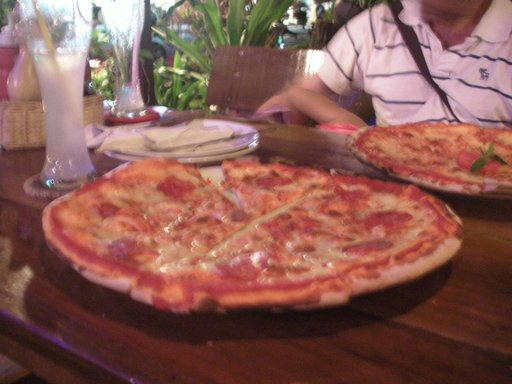

In [10]:
from PIL import Image

# 4. Buka gambar
img = Image.open(random_image_path)

# 5. Berikan metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 383.5, -0.5)

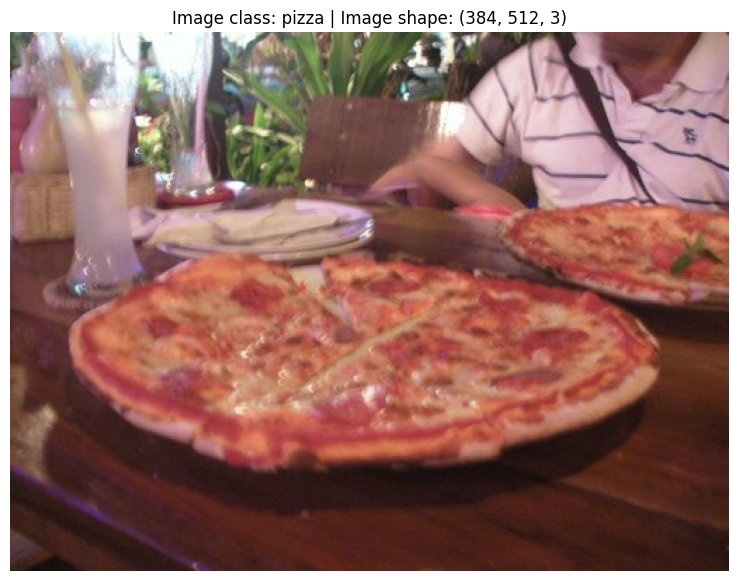

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Ubah image ke array
img_as_array = np.asarray(img)

# Plot gambar
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

## 3. Mengubah data

Sebelum kita dapat menggunakan gambar kita dengan PyTorch:
1. Ubah target data menjadi bentuk tensor (numerical representation dari gambar kita)
2. Ubah itu menjadi `torch.utils.data.Dataset` dan kemudian ubah menjadi `torch.utils.data.DataLoader` (untuk dibuatkan batch nya)

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data dengan `torchvision.transforms`

Transform membantu gambar anda untuk bisa digunakan dengan model

In [13]:
# Buatkan transform untuk gambar
data_transform = transforms.Compose([
    # Resize gambar kita ke 64*64
    transforms.Resize(size=(64,64)),

    # Balikkan gambar secara acak dengan horizontal
    transforms.RandomHorizontalFlip(p=0.5),

    # Ubah gambar menjadi torch.Tensor
    transforms.ToTensor()
])

In [14]:
data_transform(img)[:2]

tensor([[[0.3686, 0.3725, 0.7098,  ..., 0.4902, 0.6824, 0.6627],
         [0.3843, 0.4863, 0.7216,  ..., 0.6196, 0.7176, 0.7059],
         [0.4000, 0.5725, 0.6588,  ..., 0.7333, 0.7529, 0.7216],
         ...,
         [0.3137, 0.3059, 0.2863,  ..., 0.1765, 0.1686, 0.1686],
         [0.2824, 0.2784, 0.2588,  ..., 0.2000, 0.1882, 0.1647],
         [0.2314, 0.2000, 0.1333,  ..., 0.2078, 0.1922, 0.1804]],

        [[0.4078, 0.3922, 0.7059,  ..., 0.3686, 0.5569, 0.5373],
         [0.4275, 0.4627, 0.6784,  ..., 0.4980, 0.5882, 0.5725],
         [0.4314, 0.5098, 0.6039,  ..., 0.6039, 0.6118, 0.5765],
         ...,
         [0.2157, 0.2000, 0.1686,  ..., 0.0941, 0.0902, 0.0941],
         [0.1765, 0.1529, 0.1373,  ..., 0.0941, 0.0941, 0.0902],
         [0.1412, 0.1137, 0.0784,  ..., 0.0980, 0.1020, 0.0941]]])

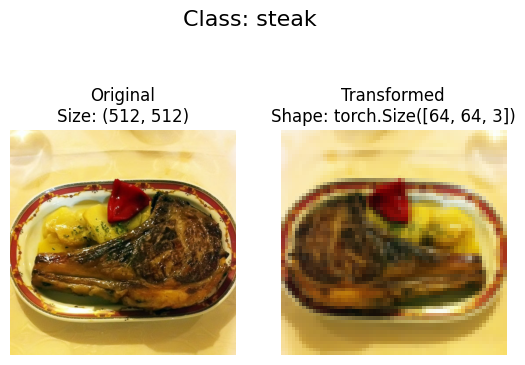

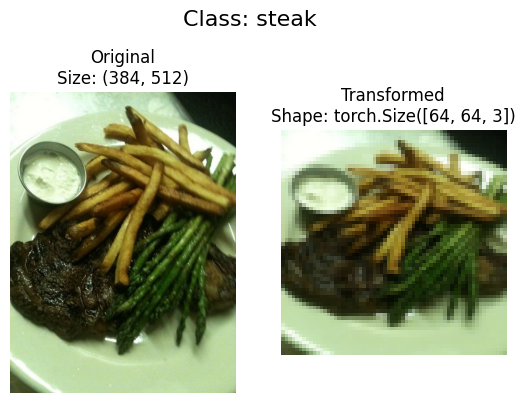

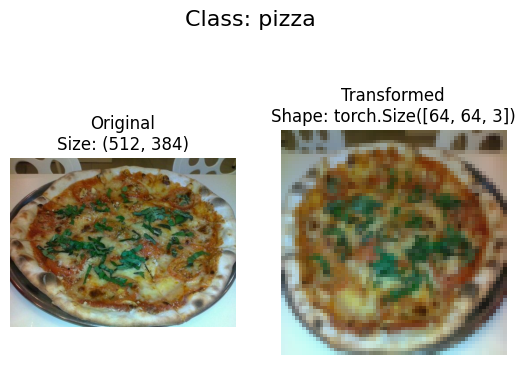

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target gambar
      transformed_image = transform(f).permute(1, 2, 0) # Kita akan ubah bentuk untuk matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)


## 4. Opsi 1: Muat data gambar dengan `ImageFolder`

Kita bisa muat klasifikasi gambar dengan menggunakan `torchvision.datasets.ImageFolder`

In [16]:
# Gunakan ImageFolder untuk membuat dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
# Ambil nama kelas dengan list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Ambil nama kelas sebagai dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Cek panjang dari dataset
len(train_data), len(test_data)

(225, 75)

In [20]:
train_data.samples[:5], train_data.targets[:5]

([('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
  ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
  ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
  ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
  ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0)],
 [0, 0, 0, 0, 0])

In [21]:
# Index didalam train_data dataset untuk mendapatkan satu gambar
img, label = train_data[0][0], train_data[0][1]
img, class_names[label]
print(f"Gambar tenspr:\n {img[:2]}")
print(f"Bentuk gambar:\n {img.shape}")
print(f"Gambar datatype: \n {img.dtype}")
print(f"Label gambar: \n {label}")
print(f"Label gambar: \n {type(label)}")

Gambar tenspr:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]]])
Bentuk gambar:
 torch.Size([3, 64, 64])
Gambar datatype: 
 torch.float32
Label gambar: 
 0
Label gambar: 
 <class 'int'>


Bentuk asli: torch.Size([3, 64, 64]) -> [C, H, W]
Permutasi Gambar: torch.Size([64, 64, 3]) -> [H, W, C]


Text(0.5, 1.0, 'pizza')

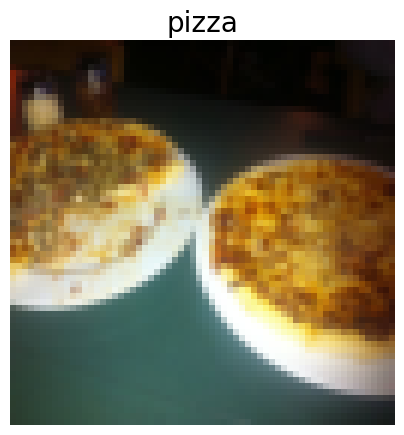

In [22]:
# Mengatur ulang dimensi -> [H, W, C]
img_permute = img.permute(1,2,0)

# Lihatkan shape berbeda
print(f"Bentuk asli: {img.shape} -> [C, H, W]")
print(f"Permutasi Gambar: {img_permute.shape} -> [H, W, C]")

# Plot gambar
plt.figure(figsize=(5,5))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=20)

## 4.1 Ubah gambar termuat menjadi `DataLoader`

Sebuah `DataLoader` akan membantu kita mengubah dataset menjadi iterable dan kita dapat mengkostumisasi `batch_size` jadi model kita dapat melihat `batch_size` gambar dalam satu waktu

In [23]:
import os
os.cpu_count()

2

In [24]:
# Ubah data latih dan data test ke DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ce4ed01e910>,
 <torch.utils.data.dataloader.DataLoader at 0x7ce4ed01d650>)

In [25]:
img, label = next(iter(train_dataloader))

print(f"Bentuk gambar: {img.shape} -> [Batch size, C, H, W]")
print(f"Label shape {label.shape}")

Bentuk gambar: torch.Size([1, 3, 64, 64]) -> [Batch size, C, H, W]
Label shape torch.Size([1])


In [26]:
!python --version

Python 3.11.11


## 5. OPsi 2: Muat Gambar dengan Kustom `Datase`

1. Bisa mengambil gambar dari file
2. Bisa mengambil kelas dari Dataset
3. Bisa mengambil kelas sebagai `dictionary` dari dataset

Pros:
* Bisa membuat dataset hampir dari papaun
* Tidak dibatasi oleh PyTorch

Cons:
* Walaupun kita dapat membuat Dataset dari apapun, itu bukan berarti akan dapat digunakan
* Mengguanakan Dataset kustom seringkali dapat memberikan masalah performa

In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [29]:
# Instans dari torchvision.dataseats.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Buat helper function untuk mendapatkan nama kelas

Kita akan mendapatkan fungsi untuk:
1. Ambil nama kelas menggunakan `os.scandir()` untuk melintasi target direktori
2. Mengeluarkan output kesalahan jika nama kelas tidak ditemukan
3. Ubah nama kelas menjadi dict dan list lalu return mereka

In [33]:
# Setup path untuk target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Ambil nama kelas dari target directory
class_name_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_name_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [45]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Cari folder kelas dalam target direktori."""

  # 1. Ambil nama kelas dari scanning target direktori
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  # 2. Berikan error jika nama kelas tidak ditemukan
  if not classes:
    raise FileNotFoundError(f"Tidak dapat menemukan kelas di {directory}")

  # 3. Buat dictoanary dari index label
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [46]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Buat `Dataset` custom untuk replikasi `ImageFolder`

Untuk membuat custom dataset kita sendiri, kita harus:

1. Membuat subclass dari `torch.utils.data.Dataset`
2. Inisiasi subclass kita dengan target direktori, lalu kita akan mentransform datanya
3. Buat atribut terpisah
  * paths - path dari gambar kita
  * transform - transform yang akan kita gunakan
  * classes - list dari target kelas kita
  * class_to_idx - dict dari target kelas yang di map ke label integer
4. Buat function untuk `load.images()`
5. Menulis ulang `__len__()` untuk mereturn panjang dari dataset kita
6. Menulis ulang `__getitem()__` untuk mereturn sample

In [47]:
# Buat kelas custom dataset
from torch.utils.data import Dataset

# 1. Subclass torch.tuils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Inisialisasi dataset kustom
  def __init__(self,
               targ_dir: str,
               transform=None):
    # Buat atribut kelas
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    # Setup transforms
    self.transform = transform

    # Buat classes dan class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Buat function untuk memuat gambar
  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    return len(self.paths)

  # 6. Overwrite __getitem__() untuk mereturn sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # Mengharapkan path dalam format: /data_folder/class_name/name.jpg
    class_idx = self.class_to_idx[class_name]

    # Transforms jika diperlukan
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [48]:
# Buat transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [49]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [50]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ce4ea143e10>,
 <__main__.ImageFolderCustom at 0x7ce4ea140e90>)

In [51]:
len(train_data), len(train_data_custom)

(225, 225)

In [52]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [53]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [55]:
# Periksa kesamaan antara ImageFolder Dataset dan ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


# 5.3 Buat fungsi untuk menampilkan gambar acak

1. Ambil `Dataset` dan beberapa parameter lain, seperti nama kelas, dan berapa banyak gambar yang akan ditampilkan
2. Untuk mencegah gambar ditampilkan banyak, kita batasi 10 gambar
3. Buat random seed untuk reproducibility
4. Ambil list dari sample acak untuk target dataset
5. Setup `matplotlib.plot`
6. Buat perulangan dari gambar acak lalu tampilkan dengan matplotlib
7. Pastikan dimensi nya [H, W, C]

In [59]:
# 1. Buat fungsi untuk mengambil dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Sesuaikan tampilan jika n nya terlalu ringgi
  if n > 10:
    n = 10
    display_shape = False
    print(f" Untuk kepentingan gambar, n tidak boleh lebih besar dari 10")

  # 3. Atur seed
  if seed:
    random.seed(seed)

  # 4. Ambil index sample random
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Buat plot
  plt.figure(figsize=(16,8))

  # 6. Lakukan perulangan index acak dan plot dengan matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Sesuaikan dimensi tensor untuk plotting
    targ_image_adjust = targ_image.permute(1,2,0) # [C, H, W] -> [H, W, C]

    # Plot smaple yang sudah di atur dimensinya
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    # Tambahkan label jika diperlukan
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
      plt.title(title)


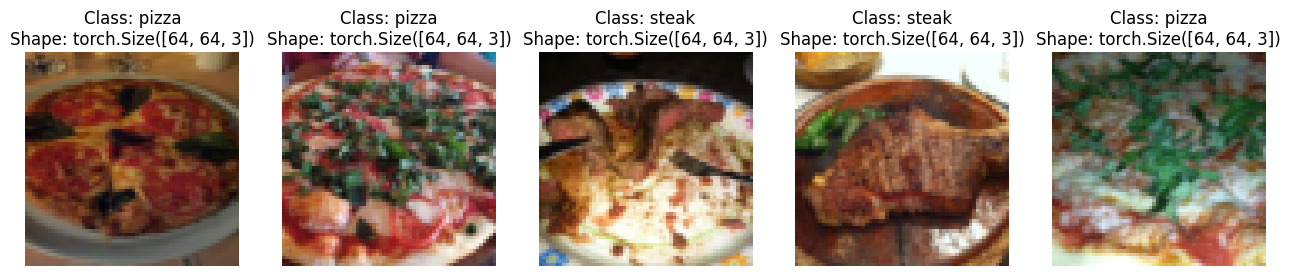

In [62]:
# Tampilkan gambar acak dari ImageFolder
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

 Untuk kepentingan gambar, n tidak boleh lebih besar dari 10


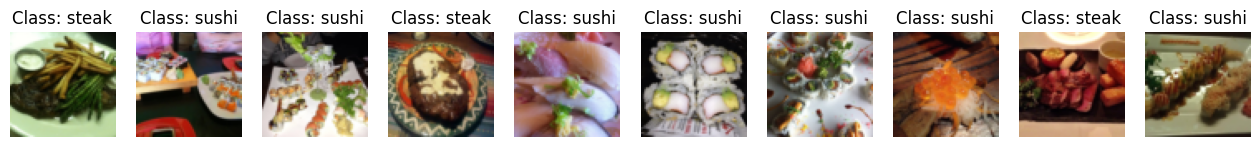

In [63]:
# Tampilkan gambar acak dari ImageFoldeCustom dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=42)
